## Multi Layer Perceptron Regression

### Preprocessing the Monthly Aggregated Data.

First we import the necessary packages. We then create the dataset by defing the *create_lag* function and use it to make the dataset we want.



In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import os
cwd = os.getcwd()
os.chdir('C:\\Users\\ekoulier\\Desktop\\GGD\\New Data\\Central_Folder')
data = pd.read_csv('br_regions_gt.csv')
data = data[['HVB', 'Date', 'WB', 'BZO', 'Trends']]
os.chdir(cwd)

In [3]:
data.head()

,HVB,Date,WB,BZO,Trends
0,29,2004-01,3,20,0
1,26,2004-02,12,11,0
2,43,2004-03,5,23,57
3,22,2004-04,8,44,47
4,41,2004-05,18,39,0


In [4]:
data.Date = pd.to_datetime(data.Date)

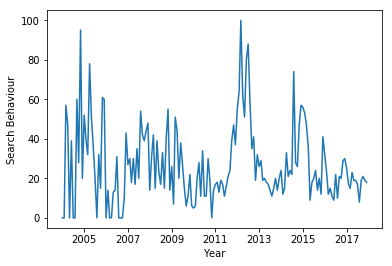

In [6]:
plt.plot(data.Date, data.Trends)
plt.ylabel('Search Behaviour')
plt.xlabel('Year')
plt.savefig('Kinkhoest Trends.png', dpi=400)
plt.show()

We make the create_lag function in order to create the dataset that contains the time lags.

In [4]:
def create_lag(df, n_lags):
    """
    Manipulates the dataset in order to create time lags for 'HVB', 'WB', 'BZO' and 'Trends'.
    """
    
    assert type(n_lags) == int
 
    for i in ['HVB', 'WB', 'BZO', 'Trends']:
        for j in range(1, n_lags + 1):
            df[i+'-'+str(j)] = df[i].shift(j)
        df[i+'+1'] = df[i].shift(-1)
        
    # We dont need to forecast the google trends    
    del df['Trends+1']
    
    # Due to the shift that creates nans, we delete the first n_lags rows and the last row.
    df = df[n_lags:].reset_index(drop = True)
    df = df[:-1]
    
    return df

In [5]:
data2 = data.copy()
data2 = data2[18:]
data2 = create_lag(data2, 4)

In [6]:
data2['Date'] = pd.to_datetime(data2['Date'], format = '%Y-%m')

In [7]:
data2.tail(n = 5)

,HVB,Date,WB,BZO,Trends,HVB-1,HVB-2,HVB-3,HVB-4,HVB+1,...,WB+1,BZO-1,BZO-2,BZO-3,BZO-4,BZO+1,Trends-1,Trends-2,Trends-3,Trends-4
140,59,2017-07-01,17,18,17,80.0,39.0,53.0,61.0,44.0,...,24.0,13.0,21.0,12.0,4.0,12.0,19.0,19.0,23.0,15.0
141,44,2017-08-01,24,12,8,59.0,80.0,39.0,53.0,58.0,...,36.0,18.0,13.0,21.0,12.0,11.0,17.0,19.0,19.0,23.0
142,58,2017-09-01,36,11,19,44.0,59.0,80.0,39.0,27.0,...,22.0,12.0,18.0,13.0,21.0,10.0,8.0,17.0,19.0,19.0
143,27,2017-10-01,22,10,21,58.0,44.0,59.0,80.0,23.0,...,23.0,11.0,12.0,18.0,13.0,10.0,19.0,8.0,17.0,19.0
144,23,2017-11-01,23,10,19,27.0,58.0,44.0,59.0,21.0,...,16.0,10.0,11.0,12.0,18.0,13.0,21.0,19.0,8.0,17.0


The Dataframe is ready. <br/>
Now we use the features X and target y. Apart from that, we use the train_test_split to separate our models. <br/>
We also use the train test split in the X_train and y_train to create a validation set.

### Multi-Layer Perceptron Architectures

#### Using two time lags.

We first test our network using two time lags. We will decide later if we should add more features. <br/>
Before everything we initialize the numpy seed.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.


In [9]:
X = data2[['HVB', 'HVB-1', 'HVB-2', 'HVB-3',  
          'WB', 'WB-1', 'WB-2', 'WB-3', 
          'BZO', 'BZO-1', 'BZO-2', 'BZO-3', 
          'Trends', 'Trends-1']]

y = data2[['HVB+1', 'WB+1', 'BZO+1']]

In [10]:
X_T, X_test, y_T, y_test = train_test_split(X, y, test_size = 0.33, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_T, y_T, test_size = 0.15, shuffle = True)

In [1]:
class NN_Modeling(object):
    
    def __init__(self, model, X_train, X_val, X_test, y_train, y_val, y_test):
        self.model = model
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        self.r2_dict = {}
        self.predictions = pd.DataFrame()
        
    def train_model(self, epochs, times):
        
        for time in range(times):
            self.model.fit(X_train, y_train, epochs =  epochs,  validation_data = (X_val, y_val))
            y_predict = np.round(self.model.predict(X_test))
            
            # Update the r2_dict and predictions attributes
            
            self.r2_dict[time] = r2_score(y_test, y_predict)
            self.predictions[time] = y_predict
            
        
        
        

def Model_1():
    # First layer
    model.add(Dense(X_train.shape[1] + 4, input_dim = X_train.shape[1]))
    model.add(Activation('linear'))
    model.add(Dropout(0.15))

    # Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    model.add(Dense(X_train.shape[1] ))
    model.add(Activation('linear'))
    model.add(Dropout(0.25))

    model.add(Dense(X_train.shape[1] - 2))
    model.add(Activation('linear'))

    # Final layer
    model.add(Dense(y_train.shape[1]))


In [13]:
#np.random.seed(2)

In [273]:
model_1a = Sequential()

# First layer
model_1a.add(Dense(X_train.shape[1] + 2, input_dim = X_train.shape[1]))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.1))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_1a.add(Dense(X_train.shape[1]))
model_1a.add(Activation('linear'))
model_1a.add(Dropout(0.15))

model_1a.add(Dense(X_train.shape[1] - 2))
model_1a.add(Activation('linear'))

# Final layer
model_1a.add(Dense(y_train.shape[1]))

# Print the parameters
model_1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 16)                240       
_________________________________________________________________
activation_85 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 14)                238       
_________________________________________________________________
activation_86 (Activation)   (None, 14)                0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 12)                180       
__________

In [274]:
H = model_1a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])
H = model_1a.fit(X_train, y_train, epochs =  65,  validation_data = (X_val, y_val))

Train on 82 samples, validate on 15 samples
Epoch 1/65
82/82 [==============================] - 1s 17ms/step - loss: 5259.5725 - mean_squared_error: 5259.5725 - acc: 0.0854 - val_loss: 3146.8640 - val_mean_squared_error: 3146.8640 - val_acc: 0.0667
Epoch 2/65
82/82 [==============================] - 0s 104us/step - loss: 4046.1525 - mean_squared_error: 4046.1525 - acc: 0.1220 - val_loss: 2519.6111 - val_mean_squared_error: 2519.6111 - val_acc: 0.0667
Epoch 3/65
82/82 [==============================] - 0s 98us/step - loss: 2820.6109 - mean_squared_error: 2820.6109 - acc: 0.1707 - val_loss: 2116.2119 - val_mean_squared_error: 2116.2119 - val_acc: 0.0667
Epoch 4/65
82/82 [==============================] - 0s 92us/step - loss: 2140.5017 - mean_squared_error: 2140.5017 - acc: 0.1707 - val_loss: 1875.8013 - val_mean_squared_error: 1875.8013 - val_acc: 0.1333
Epoch 5/65
82/82 [==============================] - 0s 122us/step - loss: 2622.8841 - mean_squared_error: 2622.8841 - acc: 0.2439 - val

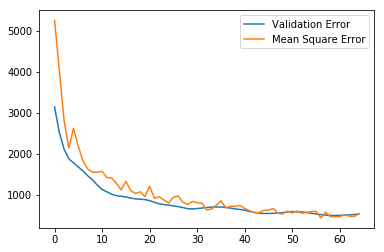

In [275]:
plt.plot(H.history['val_mean_squared_error'], label = 'Validation Error')
plt.plot(H.history['mean_squared_error'], label = 'Mean Square Error' )
plt.legend()
plt.show()

In [276]:
predictions = np.round(model_1a.predict(X_test))

In [277]:
np_y_test = np.array(y_test)

### Naive Predictor

The idea is to develop a Naive Predictor that copies the previous value of patients to the new one. 
This can be easily done just by calculating the r2 and Mean absolute error between the shift and the prediction.

In [278]:
print('Naive Predictor Metrics:')
for i in ['HVB', 'WB', 'BZO']:
    print(i+' R2 score: ',r2_score(X_test[i], y_test[i+'+1']), 
          ' Mean Absolute Error :', mean_absolute_error(X_test[i], y_test[i+'+1']))

Naive Predictor Metrics:
HVB R2 score:  0.292332634863  Mean Absolute Error : 11.7708333333
WB R2 score:  0.694273754416  Mean Absolute Error : 10.125
BZO R2 score:  0.326369038785  Mean Absolute Error : 8.6875


In [279]:
print(r2_score(predictions, np_y_test))
print(mean_absolute_error(predictions, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO']):
    print(j, 'R2 score :', r2_score(predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

0.121945498397
11.4375
HVB R2 score : 0.337824224108 Mean Absolute Error 13.6875
WB  R2 score : 0.0683333600333 Mean Absolute Error 12.7916666667
BZO R2 score : -0.0403210889506 Mean Absolute Error 7.83333333333


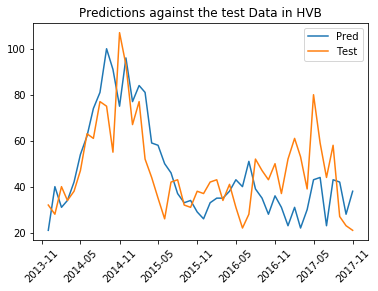

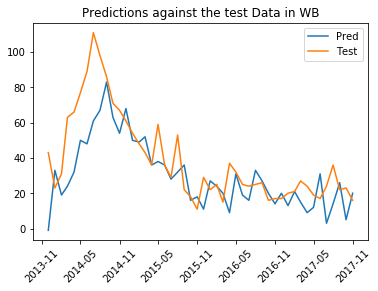

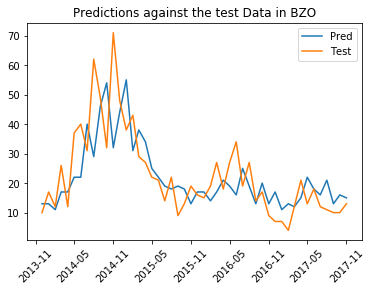

In [280]:
prediction_dataframe = pd.DataFrame({'Date' : data2['Date'][-len(y_test):], 
                         'HVB':predictions[:,0],
                       'WB': predictions[:,1],
                       'BZO': predictions[:,2]}).reset_index(drop = True)
prediction_dataframe['Date'] = pd.to_datetime(prediction_dataframe['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO']:
    plt.plot(prediction_dataframe['Date'], prediction_dataframe[i], label = 'Pred'  )
    plt.plot(prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NNυ'+i, dpi = 800)
    plt.show()

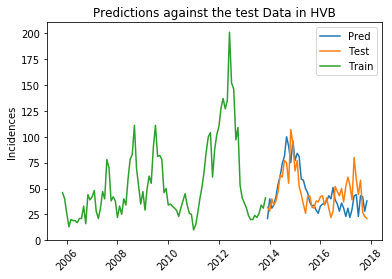

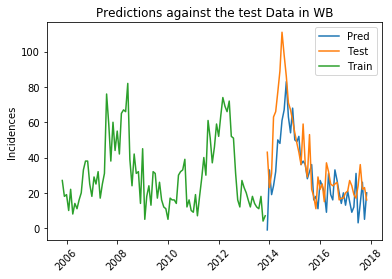

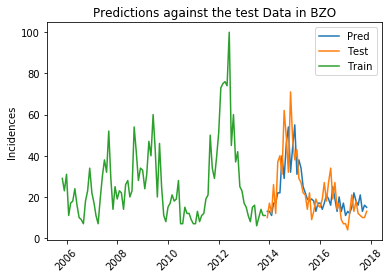

In [281]:
for i in ['HVB', 'WB', 'BZO']:
    plt.plot(prediction_dataframe['Date'], prediction_dataframe[i], label = 'Pred')
    plt.plot(prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.plot(data2['Date'][:- len(X_test)], X_T[i], label = 'Train')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    plt.ylabel('Incidences')
    #plt.savefig('Allυ'+i, dpi = 1000)
    plt.show()

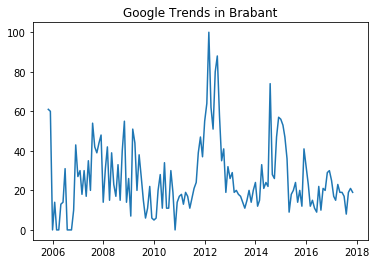

In [181]:
plt.plot(data2['Date'], data2['Trends'])
plt.title('Google Trends in Brabant')
plt.show()

## Make the interval

In [30]:
initializations = 20
NBest_initializations = 5

model_a = Sequential()

# First layer
model_a.add(Dense(X_train.shape[1] + 4, input_dim = X_train.shape[1]))
model_a.add(Activation('linear'))
model_a.add(Dropout(0.1))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_a.add(Dense(X_train.shape[1] ))
model_a.add(Activation('linear'))
model_a.add(Dropout(0.15))

model_a.add(Dense(X_train.shape[1] - 2))
model_a.add(Activation('linear'))

# Final layer
model_a.add(Dense(y_train.shape[1]))
model_a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])

# Print the parameters
#model_1a.summary()

r2_dict = {}
y_pred_df = pd.DataFrame()

best_performance_list = []


for initialization in range(initializations):
    model_a.fit(X_train, y_train, epochs =  60,  validation_data = (X_val, y_val))
    predictions = np.round(model_a.predict(X_test))
    r2_dict[initialization] = r2_score(y_test, predictions)
    
    # Make a column for each region and model in the y_pred_df
    
    for counter, region in enumerate(['HVB', 'WB', 'BZO']):
        y_pred_df[str(initialization)+region] = predictions[:,counter]
    
for best_init in range(NBest_initializations):
    best_performance_list.append(max(r2_dict, key = r2_dict.get))
    del r2_dict[max(r2_dict, key=r2_dict.get)]
    
best_columns = []

for i in best_performance_list:
    for region in ['HVB', 'WB', 'BZO']:
        best_columns.append(str(i)+region)

y_pred_df = y_pred_df[best_columns]


Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 6ms/step - loss: 10747.1123 - mean_squared_error: 10747.1123 - acc: 0.4512 - val_loss: 7550.2793 - val_mean_squared_error: 7550.2793 - val_acc: 0.4667
Epoch 2/60
82/82 [==============================] - 0s 122us/step - loss: 9618.3165 - mean_squared_error: 9618.3165 - acc: 0.4024 - val_loss: 5601.8716 - val_mean_squared_error: 5601.8716 - val_acc: 0.6000
Epoch 3/60
82/82 [==============================] - 0s 128us/step - loss: 6873.8795 - mean_squared_error: 6873.8795 - acc: 0.5488 - val_loss: 4066.5359 - val_mean_squared_error: 4066.5359 - val_acc: 0.6000
Epoch 4/60
82/82 [==============================] - 0s 110us/step - loss: 5811.3281 - mean_squared_error: 5811.3281 - acc: 0.5000 - val_loss: 2899.9270 - val_mean_squared_error: 2899.9270 - val_acc: 0.6667
Epoch 5/60
82/82 [==============================] - 0s 98us/step - loss: 3911.4253 - mean_squared_error: 3911.4253 - acc: 0.5976 - v

82/82 [==============================] - 0s 98us/step - loss: 650.9989 - mean_squared_error: 650.9989 - acc: 0.7439 - val_loss: 283.7574 - val_mean_squared_error: 283.7574 - val_acc: 0.8667
Epoch 20/60
82/82 [==============================] - 0s 73us/step - loss: 521.1643 - mean_squared_error: 521.1643 - acc: 0.7927 - val_loss: 284.1562 - val_mean_squared_error: 284.1562 - val_acc: 0.8667
Epoch 21/60
82/82 [==============================] - 0s 98us/step - loss: 614.1298 - mean_squared_error: 614.1298 - acc: 0.6951 - val_loss: 283.6277 - val_mean_squared_error: 283.6277 - val_acc: 0.8667
Epoch 22/60
82/82 [==============================] - 0s 73us/step - loss: 488.3962 - mean_squared_error: 488.3962 - acc: 0.7439 - val_loss: 282.1692 - val_mean_squared_error: 282.1692 - val_acc: 0.8667
Epoch 23/60
82/82 [==============================] - 0s 73us/step - loss: 470.5301 - mean_squared_error: 470.5301 - acc: 0.7683 - val_loss: 280.6379 - val_mean_squared_error: 280.6379 - val_acc: 0.8667
Ep

82/82 [==============================] - 0s 79us/step - loss: 369.4255 - mean_squared_error: 369.4255 - acc: 0.8293 - val_loss: 265.6790 - val_mean_squared_error: 265.6790 - val_acc: 0.8667
Epoch 40/60
82/82 [==============================] - 0s 74us/step - loss: 364.0780 - mean_squared_error: 364.0780 - acc: 0.7561 - val_loss: 265.8484 - val_mean_squared_error: 265.8484 - val_acc: 0.8667
Epoch 41/60
82/82 [==============================] - 0s 73us/step - loss: 380.8861 - mean_squared_error: 380.8861 - acc: 0.7195 - val_loss: 265.7878 - val_mean_squared_error: 265.7878 - val_acc: 0.8667
Epoch 42/60
82/82 [==============================] - 0s 98us/step - loss: 343.5126 - mean_squared_error: 343.5126 - acc: 0.8537 - val_loss: 265.6079 - val_mean_squared_error: 265.6079 - val_acc: 0.8667
Epoch 43/60
82/82 [==============================] - 0s 85us/step - loss: 345.8827 - mean_squared_error: 345.8827 - acc: 0.7561 - val_loss: 266.2582 - val_mean_squared_error: 266.2582 - val_acc: 0.8667
Ep

82/82 [==============================] - 0s 85us/step - loss: 266.9146 - mean_squared_error: 266.9146 - acc: 0.8293 - val_loss: 264.8668 - val_mean_squared_error: 264.8668 - val_acc: 0.8667
Epoch 60/60
82/82 [==============================] - 0s 85us/step - loss: 307.5778 - mean_squared_error: 307.5778 - acc: 0.8659 - val_loss: 264.1128 - val_mean_squared_error: 264.1128 - val_acc: 0.8667
Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 73us/step - loss: 305.9834 - mean_squared_error: 305.9834 - acc: 0.8415 - val_loss: 263.7997 - val_mean_squared_error: 263.7997 - val_acc: 0.8667
Epoch 2/60
82/82 [==============================] - 0s 73us/step - loss: 249.3627 - mean_squared_error: 249.3627 - acc: 0.8537 - val_loss: 264.0637 - val_mean_squared_error: 264.0637 - val_acc: 0.8667
Epoch 3/60
82/82 [==============================] - 0s 85us/step - loss: 271.2927 - mean_squared_error: 271.2927 - acc: 0.8537 - val_loss: 264.2951 - val_mean_squ

Epoch 39/60
82/82 [==============================] - 0s 85us/step - loss: 286.7580 - mean_squared_error: 286.7580 - acc: 0.8293 - val_loss: 260.3162 - val_mean_squared_error: 260.3162 - val_acc: 0.8667
Epoch 40/60
82/82 [==============================] - 0s 73us/step - loss: 264.7778 - mean_squared_error: 264.7778 - acc: 0.8537 - val_loss: 260.3276 - val_mean_squared_error: 260.3276 - val_acc: 0.8667
Epoch 41/60
82/82 [==============================] - 0s 73us/step - loss: 325.1087 - mean_squared_error: 325.1087 - acc: 0.8537 - val_loss: 260.9884 - val_mean_squared_error: 260.9884 - val_acc: 0.8667
Epoch 42/60
82/82 [==============================] - 0s 73us/step - loss: 237.0732 - mean_squared_error: 237.0732 - acc: 0.8902 - val_loss: 261.5705 - val_mean_squared_error: 261.5705 - val_acc: 0.8667
Epoch 43/60
82/82 [==============================] - 0s 134us/step - loss: 322.1703 - mean_squared_error: 322.1703 - acc: 0.8293 - val_loss: 261.9045 - val_mean_squared_error: 261.9045 - val_a

82/82 [==============================] - 0s 122us/step - loss: 239.5057 - mean_squared_error: 239.5057 - acc: 0.8415 - val_loss: 264.6977 - val_mean_squared_error: 264.6977 - val_acc: 0.8667
Epoch 20/60
82/82 [==============================] - 0s 85us/step - loss: 351.2771 - mean_squared_error: 351.2771 - acc: 0.8537 - val_loss: 266.1078 - val_mean_squared_error: 266.1078 - val_acc: 0.8667
Epoch 21/60
82/82 [==============================] - 0s 110us/step - loss: 285.4133 - mean_squared_error: 285.4133 - acc: 0.8171 - val_loss: 267.2379 - val_mean_squared_error: 267.2379 - val_acc: 0.8667
Epoch 22/60
82/82 [==============================] - 0s 73us/step - loss: 211.7359 - mean_squared_error: 211.7359 - acc: 0.8659 - val_loss: 267.7091 - val_mean_squared_error: 267.7091 - val_acc: 0.8667
Epoch 23/60
82/82 [==============================] - 0s 73us/step - loss: 285.4688 - mean_squared_error: 285.4688 - acc: 0.8293 - val_loss: 266.0905 - val_mean_squared_error: 266.0905 - val_acc: 0.8667


Epoch 59/60
82/82 [==============================] - 0s 85us/step - loss: 238.2616 - mean_squared_error: 238.2616 - acc: 0.8537 - val_loss: 266.7526 - val_mean_squared_error: 266.7526 - val_acc: 0.8000
Epoch 60/60
82/82 [==============================] - 0s 85us/step - loss: 276.5807 - mean_squared_error: 276.5807 - acc: 0.8415 - val_loss: 271.0370 - val_mean_squared_error: 271.0370 - val_acc: 0.8000
Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 104us/step - loss: 275.9478 - mean_squared_error: 275.9478 - acc: 0.8537 - val_loss: 270.1783 - val_mean_squared_error: 270.1783 - val_acc: 0.8000
Epoch 2/60
82/82 [==============================] - 0s 100us/step - loss: 265.1476 - mean_squared_error: 265.1476 - acc: 0.8537 - val_loss: 265.3966 - val_mean_squared_error: 265.3966 - val_acc: 0.8000
Epoch 3/60
82/82 [==============================] - 0s 73us/step - loss: 276.0639 - mean_squared_error: 276.0639 - acc: 0.8780 - val_loss: 262.1129 

Epoch 39/60
82/82 [==============================] - 0s 73us/step - loss: 276.1118 - mean_squared_error: 276.1118 - acc: 0.8293 - val_loss: 268.7235 - val_mean_squared_error: 268.7235 - val_acc: 0.8667
Epoch 40/60
82/82 [==============================] - 0s 85us/step - loss: 235.8381 - mean_squared_error: 235.8381 - acc: 0.8780 - val_loss: 267.8415 - val_mean_squared_error: 267.8415 - val_acc: 0.8667
Epoch 41/60
82/82 [==============================] - 0s 122us/step - loss: 282.3186 - mean_squared_error: 282.3186 - acc: 0.8659 - val_loss: 267.3303 - val_mean_squared_error: 267.3303 - val_acc: 0.8667
Epoch 42/60
82/82 [==============================] - 0s 98us/step - loss: 218.3466 - mean_squared_error: 218.3466 - acc: 0.8659 - val_loss: 267.3577 - val_mean_squared_error: 267.3577 - val_acc: 0.8667
Epoch 43/60
82/82 [==============================] - 0s 85us/step - loss: 337.7407 - mean_squared_error: 337.7407 - acc: 0.8659 - val_loss: 267.0577 - val_mean_squared_error: 267.0577 - val_a

82/82 [==============================] - 0s 85us/step - loss: 265.4921 - mean_squared_error: 265.4921 - acc: 0.8780 - val_loss: 268.5351 - val_mean_squared_error: 268.5351 - val_acc: 0.8667
Epoch 60/60
82/82 [==============================] - 0s 73us/step - loss: 275.9418 - mean_squared_error: 275.9418 - acc: 0.8780 - val_loss: 269.3530 - val_mean_squared_error: 269.3530 - val_acc: 0.8667
Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 85us/step - loss: 195.9477 - mean_squared_error: 195.9477 - acc: 0.9024 - val_loss: 267.9257 - val_mean_squared_error: 267.9257 - val_acc: 0.8667
Epoch 2/60
82/82 [==============================] - 0s 85us/step - loss: 233.5483 - mean_squared_error: 233.5483 - acc: 0.9268 - val_loss: 267.2932 - val_mean_squared_error: 267.2932 - val_acc: 0.8667
Epoch 3/60
82/82 [==============================] - 0s 73us/step - loss: 193.5067 - mean_squared_error: 193.5067 - acc: 0.8902 - val_loss: 267.0540 - val_mean_squ

Epoch 19/60
82/82 [==============================] - 0s 98us/step - loss: 215.4924 - mean_squared_error: 215.4924 - acc: 0.8780 - val_loss: 271.4480 - val_mean_squared_error: 271.4480 - val_acc: 0.8000
Epoch 20/60
82/82 [==============================] - 0s 85us/step - loss: 260.4211 - mean_squared_error: 260.4211 - acc: 0.8659 - val_loss: 274.4650 - val_mean_squared_error: 274.4650 - val_acc: 0.8000
Epoch 21/60
82/82 [==============================] - 0s 98us/step - loss: 242.9874 - mean_squared_error: 242.9874 - acc: 0.8780 - val_loss: 272.7103 - val_mean_squared_error: 272.7103 - val_acc: 0.8000
Epoch 22/60
82/82 [==============================] - 0s 92us/step - loss: 233.5329 - mean_squared_error: 233.5329 - acc: 0.9146 - val_loss: 269.3229 - val_mean_squared_error: 269.3229 - val_acc: 0.8000
Epoch 23/60
82/82 [==============================] - 0s 72us/step - loss: 220.7533 - mean_squared_error: 220.7533 - acc: 0.8780 - val_loss: 267.1096 - val_mean_squared_error: 267.1096 - val_ac

Epoch 39/60
82/82 [==============================] - ETA: 0s - loss: 185.6243 - mean_squared_error: 185.6243 - acc: 0.87 - 0s 87us/step - loss: 216.7387 - mean_squared_error: 216.7387 - acc: 0.8659 - val_loss: 273.4503 - val_mean_squared_error: 273.4503 - val_acc: 0.8000
Epoch 40/60
82/82 [==============================] - 0s 85us/step - loss: 283.2616 - mean_squared_error: 283.2616 - acc: 0.8902 - val_loss: 276.0889 - val_mean_squared_error: 276.0889 - val_acc: 0.8000
Epoch 41/60
82/82 [==============================] - 0s 85us/step - loss: 268.3037 - mean_squared_error: 268.3037 - acc: 0.8171 - val_loss: 274.2961 - val_mean_squared_error: 274.2961 - val_acc: 0.8000
Epoch 42/60
82/82 [==============================] - 0s 85us/step - loss: 252.3171 - mean_squared_error: 252.3171 - acc: 0.9024 - val_loss: 271.1947 - val_mean_squared_error: 271.1947 - val_acc: 0.8000
Epoch 43/60
82/82 [==============================] - 0s 110us/step - loss: 208.9694 - mean_squared_error: 208.9694 - acc: 

Epoch 18/60
82/82 [==============================] - 0s 73us/step - loss: 218.3165 - mean_squared_error: 218.3165 - acc: 0.8902 - val_loss: 272.4088 - val_mean_squared_error: 272.4088 - val_acc: 0.8000
Epoch 19/60
82/82 [==============================] - 0s 73us/step - loss: 260.6712 - mean_squared_error: 260.6712 - acc: 0.8659 - val_loss: 272.7664 - val_mean_squared_error: 272.7664 - val_acc: 0.8000
Epoch 20/60
82/82 [==============================] - 0s 73us/step - loss: 265.4985 - mean_squared_error: 265.4985 - acc: 0.8659 - val_loss: 271.6817 - val_mean_squared_error: 271.6817 - val_acc: 0.8000
Epoch 21/60
82/82 [==============================] - 0s 79us/step - loss: 268.0571 - mean_squared_error: 268.0571 - acc: 0.8415 - val_loss: 272.4869 - val_mean_squared_error: 272.4869 - val_acc: 0.8000
Epoch 22/60
82/82 [==============================] - 0s 92us/step - loss: 222.2298 - mean_squared_error: 222.2298 - acc: 0.9146 - val_loss: 271.7303 - val_mean_squared_error: 271.7303 - val_ac

82/82 [==============================] - 0s 73us/step - loss: 215.0169 - mean_squared_error: 215.0169 - acc: 0.8659 - val_loss: 269.7583 - val_mean_squared_error: 269.7583 - val_acc: 0.8000
Epoch 39/60
82/82 [==============================] - 0s 73us/step - loss: 227.0935 - mean_squared_error: 227.0935 - acc: 0.8902 - val_loss: 270.0902 - val_mean_squared_error: 270.0902 - val_acc: 0.8000
Epoch 40/60
82/82 [==============================] - 0s 85us/step - loss: 258.9038 - mean_squared_error: 258.9038 - acc: 0.8537 - val_loss: 271.5333 - val_mean_squared_error: 271.5333 - val_acc: 0.8000
Epoch 41/60
82/82 [==============================] - 0s 85us/step - loss: 197.9050 - mean_squared_error: 197.9050 - acc: 0.8902 - val_loss: 273.0475 - val_mean_squared_error: 273.0475 - val_acc: 0.8000
Epoch 42/60
82/82 [==============================] - 0s 122us/step - loss: 231.6366 - mean_squared_error: 231.6366 - acc: 0.8780 - val_loss: 272.6319 - val_mean_squared_error: 272.6319 - val_acc: 0.8000
E

82/82 [==============================] - 0s 85us/step - loss: 192.2597 - mean_squared_error: 192.2597 - acc: 0.8415 - val_loss: 270.4648 - val_mean_squared_error: 270.4648 - val_acc: 0.8000
Epoch 59/60
82/82 [==============================] - 0s 73us/step - loss: 209.3994 - mean_squared_error: 209.3994 - acc: 0.8902 - val_loss: 270.6706 - val_mean_squared_error: 270.6706 - val_acc: 0.8000
Epoch 60/60
82/82 [==============================] - 0s 85us/step - loss: 254.7723 - mean_squared_error: 254.7723 - acc: 0.8537 - val_loss: 271.3521 - val_mean_squared_error: 271.3521 - val_acc: 0.8000
Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 110us/step - loss: 246.0966 - mean_squared_error: 246.0966 - acc: 0.8659 - val_loss: 274.5688 - val_mean_squared_error: 274.5688 - val_acc: 0.8000
Epoch 2/60
82/82 [==============================] - 0s 98us/step - loss: 216.2096 - mean_squared_error: 216.2096 - acc: 0.8780 - val_loss: 276.9529 - val_mean_s

82/82 [==============================] - 0s 98us/step - loss: 202.1195 - mean_squared_error: 202.1195 - acc: 0.8537 - val_loss: 268.4536 - val_mean_squared_error: 268.4536 - val_acc: 0.8000
Epoch 19/60
82/82 [==============================] - 0s 85us/step - loss: 213.5825 - mean_squared_error: 213.5825 - acc: 0.8659 - val_loss: 269.0712 - val_mean_squared_error: 269.0712 - val_acc: 0.8000
Epoch 20/60
82/82 [==============================] - 0s 73us/step - loss: 251.0018 - mean_squared_error: 251.0018 - acc: 0.8780 - val_loss: 270.0714 - val_mean_squared_error: 270.0714 - val_acc: 0.8000
Epoch 21/60
82/82 [==============================] - 0s 85us/step - loss: 244.5783 - mean_squared_error: 244.5783 - acc: 0.8780 - val_loss: 270.8299 - val_mean_squared_error: 270.8299 - val_acc: 0.8000
Epoch 22/60
82/82 [==============================] - 0s 85us/step - loss: 251.6053 - mean_squared_error: 251.6053 - acc: 0.8780 - val_loss: 271.3719 - val_mean_squared_error: 271.3719 - val_acc: 0.8000
Ep

Epoch 58/60
82/82 [==============================] - 0s 85us/step - loss: 207.6647 - mean_squared_error: 207.6647 - acc: 0.8902 - val_loss: 271.4243 - val_mean_squared_error: 271.4243 - val_acc: 0.8000
Epoch 59/60
82/82 [==============================] - 0s 73us/step - loss: 210.0044 - mean_squared_error: 210.0044 - acc: 0.8780 - val_loss: 269.4151 - val_mean_squared_error: 269.4151 - val_acc: 0.8000
Epoch 60/60
82/82 [==============================] - 0s 85us/step - loss: 207.8423 - mean_squared_error: 207.8423 - acc: 0.8537 - val_loss: 269.7487 - val_mean_squared_error: 269.7487 - val_acc: 0.8000
Train on 82 samples, validate on 15 samples
Epoch 1/60
82/82 [==============================] - 0s 85us/step - loss: 201.0469 - mean_squared_error: 201.0469 - acc: 0.8659 - val_loss: 269.1997 - val_mean_squared_error: 269.1997 - val_acc: 0.8000
Epoch 2/60
82/82 [==============================] - 0s 85us/step - loss: 245.9960 - mean_squared_error: 245.9960 - acc: 0.8780 - val_loss: 267.0319 -

82/82 [==============================] - 0s 98us/step - loss: 258.6476 - mean_squared_error: 258.6476 - acc: 0.8415 - val_loss: 271.0220 - val_mean_squared_error: 271.0220 - val_acc: 0.8000
Epoch 19/60
82/82 [==============================] - 0s 85us/step - loss: 201.2480 - mean_squared_error: 201.2480 - acc: 0.8780 - val_loss: 271.6076 - val_mean_squared_error: 271.6076 - val_acc: 0.8000
Epoch 20/60
82/82 [==============================] - 0s 73us/step - loss: 223.1230 - mean_squared_error: 223.1230 - acc: 0.9024 - val_loss: 277.0922 - val_mean_squared_error: 277.0922 - val_acc: 0.8000
Epoch 21/60
82/82 [==============================] - 0s 98us/step - loss: 216.2168 - mean_squared_error: 216.2168 - acc: 0.8902 - val_loss: 281.0742 - val_mean_squared_error: 281.0742 - val_acc: 0.8000
Epoch 22/60
82/82 [==============================] - 0s 98us/step - loss: 237.6289 - mean_squared_error: 237.6289 - acc: 0.8902 - val_loss: 279.9574 - val_mean_squared_error: 279.9574 - val_acc: 0.8000
Ep

82/82 [==============================] - 0s 73us/step - loss: 284.4273 - mean_squared_error: 284.4273 - acc: 0.8902 - val_loss: 269.2333 - val_mean_squared_error: 269.2333 - val_acc: 0.8000
Epoch 38/60
82/82 [==============================] - 0s 85us/step - loss: 280.5360 - mean_squared_error: 280.5360 - acc: 0.8537 - val_loss: 270.6303 - val_mean_squared_error: 270.6303 - val_acc: 0.8000
Epoch 39/60
82/82 [==============================] - 0s 85us/step - loss: 210.5087 - mean_squared_error: 210.5087 - acc: 0.8780 - val_loss: 270.7676 - val_mean_squared_error: 270.7676 - val_acc: 0.8000
Epoch 40/60
82/82 [==============================] - 0s 85us/step - loss: 208.8844 - mean_squared_error: 208.8844 - acc: 0.9024 - val_loss: 272.5480 - val_mean_squared_error: 272.5480 - val_acc: 0.8000
Epoch 41/60
82/82 [==============================] - 0s 98us/step - loss: 238.1527 - mean_squared_error: 238.1527 - acc: 0.8780 - val_loss: 275.5858 - val_mean_squared_error: 275.5858 - val_acc: 0.8000
Ep

Epoch 17/60
82/82 [==============================] - ETA: 0s - loss: 152.8223 - mean_squared_error: 152.8223 - acc: 0.87 - 0s 85us/step - loss: 212.6837 - mean_squared_error: 212.6837 - acc: 0.8780 - val_loss: 267.3696 - val_mean_squared_error: 267.3696 - val_acc: 0.8000
Epoch 18/60
82/82 [==============================] - 0s 73us/step - loss: 225.9577 - mean_squared_error: 225.9577 - acc: 0.8659 - val_loss: 267.5185 - val_mean_squared_error: 267.5185 - val_acc: 0.8000
Epoch 19/60
82/82 [==============================] - 0s 110us/step - loss: 228.5071 - mean_squared_error: 228.5071 - acc: 0.8902 - val_loss: 269.0235 - val_mean_squared_error: 269.0235 - val_acc: 0.8000
Epoch 20/60
82/82 [==============================] - 0s 86us/step - loss: 203.7352 - mean_squared_error: 203.7352 - acc: 0.8780 - val_loss: 269.6914 - val_mean_squared_error: 269.6914 - val_acc: 0.8000
Epoch 21/60
82/82 [==============================] - ETA: 0s - loss: 189.0552 - mean_squared_error: 189.0552 - acc: 0.84 

Epoch 57/60
82/82 [==============================] - 0s 73us/step - loss: 252.8322 - mean_squared_error: 252.8322 - acc: 0.8780 - val_loss: 273.2650 - val_mean_squared_error: 273.2650 - val_acc: 0.8000
Epoch 58/60
82/82 [==============================] - 0s 73us/step - loss: 231.2974 - mean_squared_error: 231.2974 - acc: 0.8537 - val_loss: 271.4539 - val_mean_squared_error: 271.4539 - val_acc: 0.8000
Epoch 59/60
82/82 [==============================] - 0s 85us/step - loss: 199.8664 - mean_squared_error: 199.8664 - acc: 0.8537 - val_loss: 270.5245 - val_mean_squared_error: 270.5245 - val_acc: 0.8000
Epoch 60/60
82/82 [==============================] - 0s 73us/step - loss: 209.2626 - mean_squared_error: 209.2626 - acc: 0.8902 - val_loss: 270.6601 - val_mean_squared_error: 270.6601 - val_acc: 0.8000


In [31]:
y_pred_df.head()

,5HVB,5WB,5BZO,4HVB,4WB,4BZO,3HVB,3WB,3BZO,18HVB,18WB,18BZO,6HVB,6WB,6BZO
0,21.0,9.0,10.0,24.0,10.0,11.0,25.0,11.0,11.0,22.0,11.0,10.0,22.0,9.0,10.0
1,29.0,18.0,13.0,32.0,17.0,13.0,31.0,16.0,12.0,30.0,24.0,15.0,30.0,20.0,14.0
2,26.0,25.0,15.0,28.0,25.0,15.0,28.0,25.0,15.0,27.0,28.0,15.0,26.0,25.0,15.0
3,42.0,26.0,21.0,43.0,25.0,21.0,41.0,24.0,19.0,48.0,29.0,23.0,44.0,27.0,22.0
4,41.0,40.0,19.0,44.0,39.0,19.0,46.0,39.0,19.0,38.0,45.0,20.0,40.0,40.0,20.0


In [36]:
temp_reg = []
for region in ['HVB', 'WB', 'BZO']:
    
    for best_i in best_performance_list:
        temp_reg.append(str(best_i)+region)
    
y_pred_df['Ave WB'] = (y_pred_df['5WB'] + y_pred_df['3WB'] + y_pred_df['18WB'])/3

In [38]:
y_pred_df['Ave WB']

0     10.333333
1     19.333334
2     26.000000
3     26.333334
4     41.333332
5     46.000000
6     63.666668
7     67.666664
8     83.000000
9     88.666664
10    79.333336
11    68.000000
12    64.333336
13    59.000000
14    52.000000
15    41.666668
16    39.333332
17    32.333332
18    36.666668
19    36.000000
20    31.666666
21    36.666668
22    27.000000
23    24.666666
24    16.666666
25    22.666666
26    21.333334
27    23.333334
28    20.666666
29    23.000000
30    28.333334
31    28.333334
32    23.000000
33    23.666666
34    21.666666
35    20.333334
36    15.666667
37    16.666666
38    14.666667
39    17.666666
40    22.666666
41    23.666666
42    19.333334
43    22.000000
44    14.666667
45    22.000000
46    24.333334
47    21.666666
Name: Ave WB, dtype: float32

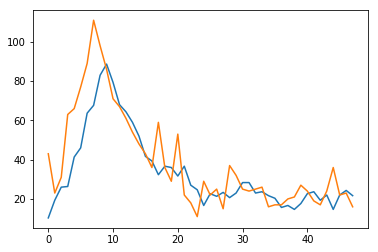

In [45]:
plt.plot(y_pred_df['Ave WB'])
plt.plot(y_test['WB+1'].reset_index(drop = True))
plt.show()

In [41]:
y_test

,HVB+1,WB+1,BZO+1
97,32.0,43.0,10.0
98,28.0,23.0,17.0
99,40.0,31.0,12.0
100,34.0,63.0,26.0
101,38.0,66.0,12.0
102,47.0,77.0,37.0
103,63.0,89.0,40.0
104,61.0,111.0,31.0
105,77.0,98.0,62.0
106,75.0,86.0,49.0


In [ ]:
max(r2_dict, key=r2_dict.get)

In [ ]:
y_test.head()

In [33]:
r2_dict

{0: 0.3443341011668184,
 1: 0.49366369540126859,
 2: 0.49985224336246487,
 7: 0.48264178790305762,
 8: 0.49117004883657023,
 9: 0.48881719145956315,
 10: 0.49481430830275652,
 11: 0.50162527279180791,
 12: 0.48362943714944295,
 13: 0.48496424974877755,
 14: 0.47109406346156063,
 15: 0.49158501792155063,
 16: 0.4974495235970437,
 17: 0.4805413551082815,
 19: 0.47358348171444015}

In [ ]:
model_1a.predict(X_test)

In [ ]:
model_1a.predict(X_test)

## 2nd Model with Dropout

In [ ]:
model_2a = Sequential()

# First layer
model_2a.add(Dense(X_train.shape[1] + 2, input_dim = X_train.shape[1]))
model_2a.add(Activation('linear'))


# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_2a.add(Dense(X_train.shape[1] + 4))
model_2a.add(Activation('relu'))
model_2a.add(Dropout(0.2))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_2a.add(Dense(X_train.shape[1] - 6))
model_2a.add(Activation('linear'))

# Final layer
model_2a.add(Dense(y_train.shape[1]))

# Print the parameters
model_2a.summary()

In [ ]:
model_2a.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse'])
H2 = model_1a.fit(X_train, y_train, epochs =  80,  validation_data = (X_val, y_val))

In [ ]:
plt.plot(H2.history['val_mean_squared_error'], label = 'Validation Error')
plt.plot(H2.history['mean_squared_error'], label = 'Mean Square Error' )
plt.legend()
plt.show()

In [ ]:
predictions2 = model_2a.predict(X_test)

In [ ]:
print(r2_score(predictions2, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO']):
    print(j, 'R2 score :', r2_score(predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

In [ ]:
prediction_dataframe2 = pd.DataFrame({'Date' : data2['Date'][-len(y_test):], 
                         'HVB':predictions2[:,0],
                       'WB': predictions2[:,1],
                       'BZO': predictions2[:,2]}).reset_index(drop = True)
prediction_dataframe2['Date'] = pd.to_datetime(prediction_dataframe2['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO']:
    plt.plot(prediction_dataframe2['Date'], prediction_dataframe2[i], label = 'Pred')
    plt.plot(prediction_dataframe2['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NN '+i)
    plt.show()

## Normalization

Here we normalize the columns to see if the performance of the model gets improved.

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = data2[['HVB', 'HVB-1', 'HVB-2', 'HVB-3',  
          'WB', 'WB-1', 'WB-2', 'WB-3', 
          'BZO', 'BZO-1', 'BZO-2', 'BZO-3', 
          'Trends', 'Trends-1', 'Trends-2']].copy()

scaler.fit(X_scaled)

X_scaled = scaler.fit_transform(X_scaled)

y_scaled = data2[['HVB+1', 'WB+1', 'BZO+1']].copy()

X_sc_T, X_sc_test, y_T, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.33, shuffle = False)
X_sc_train, X_sc_val, y_train, y_val = train_test_split(X_sc_T, y_T, test_size = 0.15, shuffle = True)

In [ ]:
model_1b = Sequential()

# First layer
model_1b.add(Dense(X_sc_train.shape[1] + 4, input_dim = X_sc_train.shape[1]))
model_1b.add(Activation('linear'))
model_1b.add(Dropout(0.15))

# Second layer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
model_1b.add(Dense(X_train.shape[1] + 2))
model_1b.add(Activation('linear'))


model_1b.add(Dense(X_train.shape[1]))
model_1b.add(Activation('relu'))

# Final layer
model_1b.add(Dense(y_train.shape[1]))

# Print the parameters
model_1b.summary()

In [ ]:
H = model_1b.compile(loss = mean_squared_error,  optimizer = 'adam', metrics = ['mse', 'accuracy'])
H = model_1b.fit(X_sc_train, y_train, epochs =  160,  validation_data = (X_val, y_val))

In [ ]:
sc_predictions = np.round(model_1b.predict(X_sc_test))

In [ ]:
print(r2_score(sc_predictions, np_y_test))

for i, j in enumerate(['HVB', 'WB ', 'BZO']):
    print(j, 'R2 score :', r2_score(sc_predictions[:,i], np_y_test[:,i]), 
          'Mean Absolute Error', mean_absolute_error(predictions[:,i], np_y_test[:,i]))

In [ ]:
sc_prediction_dataframe = pd.DataFrame({'Date' : data2['Date'][-len(y_test):], 
                         'HVB': sc_predictions[:,0],
                       'WB': sc_predictions[:,1],
                       'BZO': sc_predictions[:,2]}).reset_index(drop = True)
sc_prediction_dataframe['Date'] = pd.to_datetime(sc_prediction_dataframe['Date'], format = '%Y-%m')

for i in ['HVB', 'WB', 'BZO']:
    plt.plot(sc_prediction_dataframe['Date'], sc_prediction_dataframe[i], label = 'Pred'  )
    plt.plot(sc_prediction_dataframe['Date'], y_test[i+'+1'], label = 'Test')
    plt.legend()
    plt.title('Predictions against the test Data in '+i)
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)
    #plt.savefig('NNζ'+i)
    plt.show()

In [122]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/wind_speed_laurel_nebraska.csv')

upper_bound = go.Scatter(
    name='Upper Bound',
    x=df['Time'],
    y=df['10 Min Sampled Avg']+df['10 Min Std Dev'],
    mode='lines',
    marker=dict(color="444"),
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

trace = go.Scatter(
    name='Measurement',
    x=df['Time'],
    y=df['10 Min Sampled Avg'],
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

lower_bound = go.Scatter(
    name='Lower Bound',
    x=df['Time'],
    y=df['10 Min Sampled Avg']-df['10 Min Std Dev'],
    marker=dict(color="444"),
    line=dict(width=0),
    mode='lines')

# Trace order can be important
# with continuous error bars
data = [lower_bound, trace, upper_bound]

layout = go.Layout(
    yaxis=dict(title='Wind speed (m/s)'),
    title='Continuous, variable value error bars.<br>Notice the hover text!',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-continuous-error-bars')

In [ ]:
di = pd.DataFrame()

In [ ]:
di['1'] = range(6)

In [ ]:
di